<a href="https://colab.research.google.com/github/ematala/satellite-segmentation/blob/main/CNN_Eric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, datetime, math
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from seaborn import heatmap
from sklearn.utils import class_weight

In [2]:
%load_ext tensorboard
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
x_train = np.load('/content/drive/MyDrive/Colab Notebooks/data/train.npz')['bands']
y_train = np.load('/content/drive/MyDrive/Colab Notebooks/data/train.npz')['lulc']

x_test = np.load('/content/drive/MyDrive/Colab Notebooks/data/public_test.npz')['bands']

In [5]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify = y_train)
f'train: {x_train.shape} {y_train.shape}, validation: {x_val.shape} {y_val.shape}'

'train: (8000, 12, 33, 33, 6) (8000,), validation: (2000, 12, 33, 33, 6) (2000,)'

In [6]:
x_train_no_data_removed = x_train[y_train != 0, :, :, :, :]
x_val_no_data_removed = x_val[y_val != 0, :, :, :, :]
y_train_no_data_removed = y_train[y_train != 0]
y_val_no_data_removed = y_val[y_val != 0]

x_train_only_no_data = x_train[y_train == 0, :, :, :, :]
x_val_only_no_data = x_val[y_val == 0, :, :, :, :]
y_train_only_no_data = y_train[y_train == 0]
y_val_only_no_data = y_val[y_val == 0]

In [7]:
classes = np.array(['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Wetlands', 'Tundra', 'Artificial Surface', 'Bareland', 'Snow and Ice'])

In [8]:
np.histogram(y_train, bins=list(range(len(classes))))[0] / y_train.shape[0] * 100

array([13.0875,  2.375 , 57.9625, 11.25  ,  7.7   ,  0.575 ,  0.    ,
        0.    ,  2.175 ,  4.875 ])

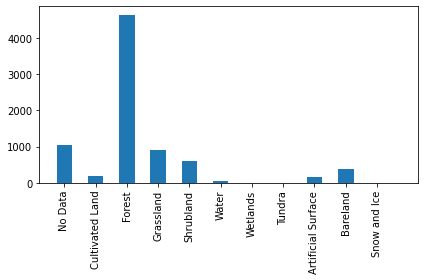

In [9]:
plt.hist(y_train, bins=list(range(len(classes) + 1)), width=0.5, align='mid')
plt.xticks(ticks=[i + 0.25 for i in range(len(classes))], labels=classes, rotation=90)
plt.tight_layout()
plt.show()

In [10]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv3D(64, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(12,33,33,6)))
model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2)))
model.add(tf.keras.layers.BatchNormalization(center=True, scale=True))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv3D(64, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2)))
model.add(tf.keras.layers.BatchNormalization(center=True, scale=True))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_uniform'))

model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 12, 31, 31, 64)    3520      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 12, 15, 15, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 15, 15, 64)    256       
_________________________________________________________________
dropout (Dropout)            (None, 12, 15, 15, 64)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 12, 13, 13, 64)    36928     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 12, 6, 6, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 6, 6, 64)      2

In [11]:
# train model with labelled data only
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(x_train_no_data_removed, y_train_no_data_removed, epochs=10, batch_size=64, validation_split=0.2, validation_data=(x_val_no_data_removed, y_val_no_data_removed), callbacks=[tensorboard_callback])

Epoch 1/10
87/87 [==============================] - 40s 94ms/step - loss: 1.8101 - accuracy: 0.6827 - val_loss: 1.5290 - val_accuracy: 0.6528
Epoch 2/10
87/87 [==============================] - 7s 76ms/step - loss: 0.8418 - accuracy: 0.7557 - val_loss: 1.7750 - val_accuracy: 0.6334
Epoch 3/10
87/87 [==============================] - 7s 75ms/step - loss: 0.6711 - accuracy: 0.7886 - val_loss: 1.4957 - val_accuracy: 0.6700
Epoch 4/10
87/87 [==============================] - 7s 77ms/step - loss: 0.5433 - accuracy: 0.8148 - val_loss: 1.4377 - val_accuracy: 0.6729
Epoch 5/10
87/87 [==============================] - 7s 76ms/step - loss: 0.4233 - accuracy: 0.8533 - val_loss: 1.2820 - val_accuracy: 0.6441
Epoch 6/10
87/87 [==============================] - 7s 77ms/step - loss: 0.3681 - accuracy: 0.8738 - val_loss: 1.1093 - val_accuracy: 0.6937
Epoch 7/10
87/87 [==============================] - 7s 76ms/step - loss: 0.2862 - accuracy: 0.8979 - val_loss: 0.8333 - val_accuracy: 0.7664
Epoch 8/10
8

In [12]:
# save model
model.save('model')
#model = tf.keras.models.load_model('model')

INFO:tensorflow:Assets written to: model/assets


In [13]:
# predict the labels for unlabelled data
preds_only_no_data = model.predict(x_train_only_no_data)
# extract the classes
preds_only_no_data_classes = preds_only_no_data.argmax(axis=1)
# replace no data label with predicted labels from the model
y_train[y_train == 0] = preds_only_no_data_classes

In [14]:
np.histogram(y_train, bins=list(range(len(classes))))[0] / y_train.shape[0] * 100

array([ 0.    ,  2.6375, 68.35  , 12.6625,  7.925 ,  0.5875,  0.    ,
        0.    ,  2.4625,  5.375 ])

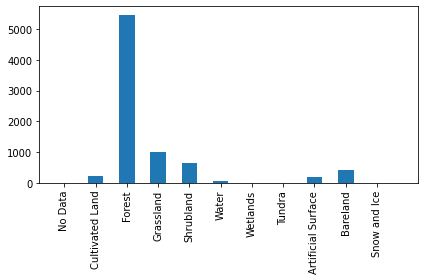

In [15]:
plt.hist(y_train, bins=list(range(len(classes) + 1)), width=0.5, align='mid')
plt.xticks(ticks=[i + 0.25 for i in range(len(classes))], labels=classes, rotation=90)
plt.tight_layout()
plt.show()

In [16]:
# add lower sampling weights for forest label due to imbalanced classes
sample_weights = np.ones(shape=(len(y_train),))
sample_weights[y_train == 2] = 0.3

# balance out classes by use of util function
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
print(class_weights)

class_weight_dict = {
    0: 0,
    1: class_weights[0],
    2: class_weights[1] + 1,
    3: class_weights[2] + 2.5,
    4: class_weights[3] + 2.5,
    5: class_weights[4] - 15,
    6: 0,
    7: 0,
    8: class_weights[5],
    9: class_weights[6],
    10: 0
}

class_weight_dict

[ 5.41638456  0.20900826  1.12819066  1.80261379 24.31610942  5.80130529
  2.65780731]


{0: 0,
 1: 5.416384563303994,
 2: 1.209008255826105,
 3: 3.6281906642222537,
 4: 4.302613789995494,
 5: 9.316109422492403,
 6: 0,
 7: 0,
 8: 5.8013052936910805,
 9: 2.6578073089700998,
 10: 0}

In [17]:
# train full model
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2, validation_data=(x_val, y_val), callbacks=[tensorboard_callback], class_weight=class_weight_dict, sample_weight=sample_weights)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10
100/100 [==============================] - 9s 86ms/step - loss: 3.8285 - accuracy: 0.5786 - val_loss: 1.9656 - val_accuracy: 0.2956
Epoch 2/10
100/100 [==============================] - 8s 77ms/step - loss: 1.7656 - accuracy: 0.6256 - val_loss: 0.7226 - val_accuracy: 0.5969
Epoch 3/10
100/100 [==============================] - 8s 77ms/step - loss: 1.2512 - accuracy: 0.7028 - val_loss: 0.6513 - val_accuracy: 0.6637
Epoch 4/10
100/100 [==============================] - 8s 78ms/step - loss: 1.0245 - accuracy: 0.7409 - val_loss: 0.6134 - val_accuracy: 0.6706
Epoch 5/10
100/100 [==============================] - 8s 78ms/step - loss: 0.7774 - accuracy: 0.7833 - val_loss: 0.5745 - val_accuracy: 0.6988
Epoch 6/10
100/100 [==============================] - 8s 78ms/step - loss: 0.6027 - accuracy: 0.8248 - val_loss: 0.6682 - val_accuracy: 0.6775
Epoc

In [18]:
#%tensorboard --logdir logs/fit

In [19]:
# predict labels
preds = model.predict(x_train)
# extract classes
preds_classes = preds.argmax(axis=1)

In [20]:
print(f"Accuracy: {accuracy_score(y_train, preds_classes)*100}")
print(classification_report(y_train, preds_classes))

Accuracy: 90.3
              precision    recall  f1-score   support

           1       0.66      0.93      0.77       211
           2       0.98      0.91      0.95      5468
           3       0.73      0.92      0.82      1013
           4       0.75      0.84      0.79       634
           5       0.95      0.85      0.90        47
           8       0.73      0.84      0.78       197
           9       0.97      0.90      0.93       430

    accuracy                           0.90      8000
   macro avg       0.83      0.88      0.85      8000
weighted avg       0.92      0.90      0.91      8000



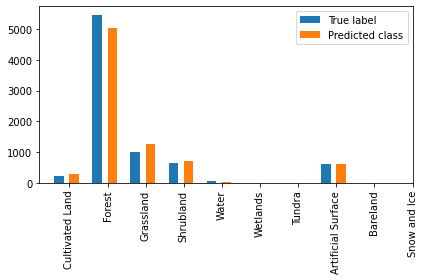

In [21]:
plt.hist([y_train, preds_classes], bins=range(1, len(classes[1:])), width=0.25, align='mid')
plt.xticks(ticks=[i + 1.5 for i in range(len(classes[1:]))], labels=classes[1:], rotation=90)
plt.legend(['True label', 'Predicted class'])
plt.tight_layout()
plt.show()

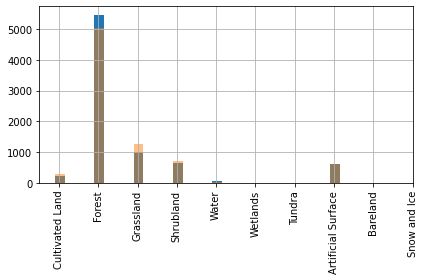

In [22]:
# histogram of preds vs true labels
preds_df = pd.DataFrame({'true':y_train, 'preds':preds_classes})

preds_df['true'].hist(bins=range(1, len(classes[1:])), width=0.25, align='mid')
preds_df['preds'].hist(bins=range(1, len(classes[1:])), width=0.25, align='mid', alpha=0.5)
plt.xticks(ticks=[i + 1.1 for i in range(len(classes[1:]))], labels=classes[1:], rotation=90)
plt.tight_layout()
plt.show()

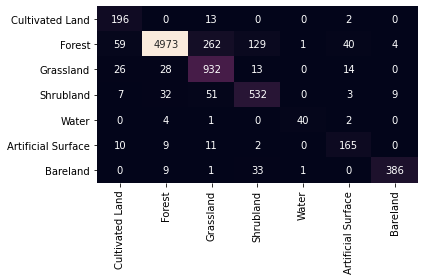

In [23]:
# confusion matrix
conf_df = pd.DataFrame(confusion_matrix(preds_df['true'], preds_df['preds']), index=classes[np.unique(preds_classes)], columns=classes[np.unique(preds_classes)])
heatmap(conf_df, annot=True, fmt='d', cbar=False)
plt.tight_layout()
plt.show()

In [24]:
# extract single test image
img = x_test[3, :, :, :]
# window dimensions
x, y = 33, 33
# prediction matrix
pred = np.zeros((img.shape[0], img.shape[1]))
# all subwindows
windows = []

# iterate over all rows and columns of the test image
for i in range(img.shape[0]):
  for j in range(img.shape[1]):
    # calculate window bounds
    left, right, top, bottom = math.floor(i - x/2), math.floor(i + x/2), math.floor(j - y/2), math.floor(j + y/2)
    # check out of bounds
    if not (left < 0 or right > img.shape[0] or top < 0 or bottom > img.shape[1]):
      # takes forever
      #pred[i, j] = model.predict(np.array([x_test[:, left:right, top:bottom, :]])).argmax(1)[0]
      pred[i, j] = 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


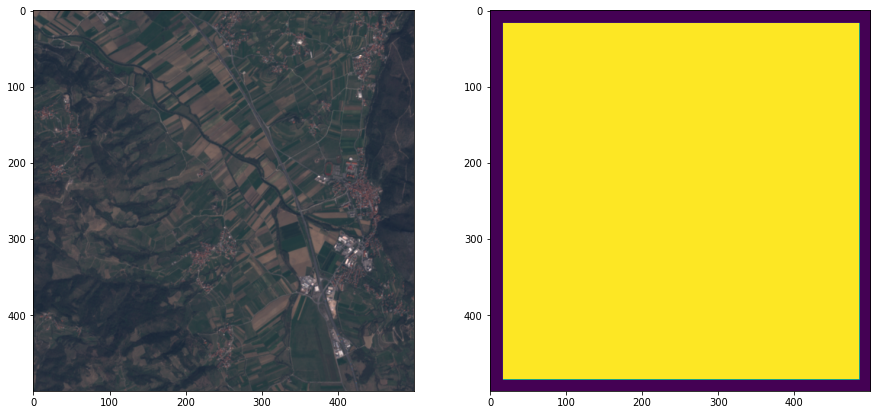

In [25]:
# plot image and predicted labels
month = 3

f, (sat, lulc) = plt.subplots(1, 2, figsize=(15,15))

band = 0.5 + 2.5 * (np.flip(x_test[month, :, :, :3], -1) + .3 - 0.5)
sat.imshow(band, cmap='gray')

lulc.imshow(pred)

plt.show()